<a href="https://colab.research.google.com/github/andrillion/travel-site/blob/master/aco_osmr_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# An ant colony optimization approach for solving the travelling salesman problem

### Modul 1: Importera Bibliotek och Definiera AntColonyOptimizer-klassen

In [1]:
!pip install polyline
import numpy as np
import random
import requests
import polyline
import folium
import pickle
import os

class AntColonyOptimizer:
    def __init__(self, num_cities, num_ants, evaporation_rate, alpha, beta, initial_pheromone, max_iterations):
        self.num_cities = num_cities
        self.num_ants = num_ants
        self.evaporation_rate = evaporation_rate
        self.alpha = alpha  # Pheromone importance
        self.beta = beta    # Distance importance
        self.pheromone_matrix = np.full((num_cities, num_cities), initial_pheromone)
        self.distance_matrix = None  # To be initialized separately
        self.max_iterations = max_iterations

    def initialize_distance_matrix(self, distances):
        self.distance_matrix = distances

    def run(self):
        best_tour = None
        best_length = float('inf')
        length_history = []  # Initialize length history

        for iteration in range(self.max_iterations):
            print(f"Starting iteration {iteration + 1}/{self.max_iterations}")

            all_tours = self.construct_solution()
            self.update_pheromones(all_tours)

            for tour in all_tours:
                length = self.calculate_tour_length(tour)
                if length < best_length:
                    best_length = length
                    best_tour = tour

            length_history.append(best_length)  # Record the best length of this iteration

        return best_tour, best_length, length_history

    def construct_solution(self):
        all_tours = []
        for _ in range(self.num_ants):
            tour = self.build_ant_tour()
            all_tours.append(tour)
        return all_tours

    def build_ant_tour(self):
        tour = []
        visited = set()
        current_city = random.randint(0, self.num_cities - 1)
        tour.append(current_city)
        visited.add(current_city)

        for _ in range(self.num_cities - 1):
            next_city = self.select_next_city(current_city, visited)
            tour.append(next_city)
            visited.add(next_city)
            current_city = next_city

        tour.append(tour[0])  # Ensure the tour is closed by adding the start point at the end
        return tour

    def select_next_city(self, current_city, visited):
        probabilities = []
        for city in range(self.num_cities):
            if city not in visited:
                trail = self.pheromone_matrix[current_city][city] ** self.alpha
                visibility = (1.0 / (self.distance_matrix[current_city][city] + 1e-8)) ** self.beta
                probabilities.append(trail * visibility)
            else:
                probabilities.append(0)

        probabilities = np.array(probabilities) / np.sum(probabilities)
        next_city = np.random.choice(self.num_cities, p=probabilities)
        return next_city

    def calculate_tour_length(self, tour):
        length = 0
        for i in range(len(tour) - 1):
            length += self.distance_matrix[tour[i]][tour[i+1]]
        return length

    def update_pheromones(self, all_tours):
        self.evaporate_pheromones()
        self.deposit_pheromones(all_tours)

    def evaporate_pheromones(self):
        self.pheromone_matrix *= (1 - self.evaporation_rate)

    def deposit_pheromones(self, all_tours):
        for tour in all_tours:
            contribution = self.calculate_tour_contribution(tour)
            for i in range(len(tour) - 1):
                self.pheromone_matrix[tour[i]][tour[i+1]] += contribution

    def calculate_tour_contribution(self, tour):
        return 1.0 / self.calculate_tour_length(tour)


### Modul 2: Generera Distansmatris och Rutter




In [2]:
def get_route_geometry(start_coords, end_coords):
    url = f"http://router.project-osrm.org/route/v1/driving/{start_coords[1]},{start_coords[0]};{end_coords[1]},{end_coords[0]}?overview=full"
    response = requests.get(url)
    data = response.json()
    geometry = data['routes'][0]['geometry']
    return polyline.decode(geometry)

def plot_tour_on_map(tour, locations):
    # Create a map centered around the first location
    first_location = list(locations.keys())[tour[0]]
    map = folium.Map(location=locations[first_location], zoom_start=12)

    # Add markers for each location
    for loc_name, coords in locations.items():
        folium.Marker(coords, popup=loc_name).add_to(map)

    # Draw lines for the tour
    tour_coords = [locations[list(locations.keys())[i]] for i in tour]
    tour_coords.append(locations[list(locations.keys())[tour[0]]])  # Ensure the tour is closed by adding the start point again

    # Add each segment to the map
    for i in range(len(tour) - 1):
        start = locations[list(locations.keys())[tour[i]]]
        end = locations[list(locations.keys())[tour[i + 1]]]
        route_geom = get_route_geometry(start, end)
        folium.PolyLine(route_geom, color="blue", weight=2.5, opacity=1).add_to(map)

    return map

def save_distance_matrix(filename, distance_matrix, route_geometries):
    with open(filename, 'wb') as f:
        pickle.dump((distance_matrix, route_geometries), f)

def load_distance_matrix(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

def generate_or_load_distances(locations, filename):
    if os.path.exists(filename):
        return load_distance_matrix(filename)
    else:
        num_cities = len(locations)
        distance_matrix = np.zeros((num_cities, num_cities))
        route_geometries = {}
        loc_list = list(locations.values())

        for i in range(num_cities):
            for j in range(num_cities):
                if i != j:
                    coords_i = loc_list[i]
                    coords_j = loc_list[j]
                    url = f"http://router.project-osrm.org/route/v1/driving/{coords_i[1]},{coords_i[0]};{coords_j[1]},{coords_j[0]}?overview=full"
                    response = requests.get(url)
                    data = response.json()
                    distance = data['routes'][0]['distance'] / 1000  # Convert meters to kilometers
                    distance_matrix[i][j] = distance
                    route_geometries[(i, j)] = data['routes'][0]['geometry']
                else:
                    distance_matrix[i][j] = float('inf')

        save_distance_matrix(filename, distance_matrix, route_geometries)
        return distance_matrix, route_geometries


### Modul 3: Definiera Platser i Stockholm





In [3]:
# Define locations in Stockholm
stockholm_locations = {
    "Gamla Stan": (59.3251, 18.0711),
    "Vasa Museum": (59.3294, 18.0915),
    "Skansen": (59.3257, 18.0961),
    "Royal Palace": (59.3269, 18.0737),
    "Djurgarden": (59.3298, 18.1167),
    "Fotografiska": (59.3177, 18.0844),
    "Gröna Lund": (59.3230, 18.0963),
    "Moderna Museet": (59.3263, 18.0846),
    "Stockholm City Hall": (59.3275, 18.0544),
    "ABBA The Museum": (59.3240, 18.0962),
    "Nobel Prize Museum": (59.3247, 18.0707),
    "Stockholm Cathedral": (59.3258, 18.0709),
    "Nordiska Museet": (59.3295, 18.0908),
    "Stockholm Olympic Stadium": (59.3459, 18.0794),
    "Kungstradgarden Park": (59.3318, 18.0702),
    "Monteliusvagen": (59.3190, 18.0581),
    "Ostermalm Market Hall": (59.3350, 18.0776),
    "The Royal Dramatic Theatre": (59.3308, 18.0735),
    "Humlegarden": (59.3382, 18.0728),
    "Stortorget": (59.3248, 18.0704)
}

### Modul 4: Körning av Scriptet

In [4]:
# Generate or load the distance matrix
filename = 'distance_matrix.pkl'
distance_matrix, route_geometries = generate_or_load_distances(stockholm_locations, filename)

# Run ACO
num_cities = len(stockholm_locations)
aco = AntColonyOptimizer(
    num_cities=num_cities,
    num_ants=5,
    evaporation_rate=0.1,
    alpha=1.0,
    beta=2.0,
    initial_pheromone=0.1,
    max_iterations=50
)
aco.initialize_distance_matrix(distance_matrix)

best_tour, best_length, length_history = aco.run()
print("Best Tour:", [list(stockholm_locations.keys())[i] for i in best_tour])
print("Best Length:", best_length)

# Plot the tour on the map
tour_map = plot_tour_on_map(best_tour, stockholm_locations)

# Save the map as an HTML file
tour_map.save("tsp_solution_2024.html")

# Display the map
tour_map


Starting iteration 1/50
Starting iteration 2/50
Starting iteration 3/50
Starting iteration 4/50
Starting iteration 5/50
Starting iteration 6/50
Starting iteration 7/50
Starting iteration 8/50
Starting iteration 9/50
Starting iteration 10/50
Starting iteration 11/50
Starting iteration 12/50
Starting iteration 13/50
Starting iteration 14/50
Starting iteration 15/50
Starting iteration 16/50
Starting iteration 17/50
Starting iteration 18/50
Starting iteration 19/50
Starting iteration 20/50
Starting iteration 21/50
Starting iteration 22/50
Starting iteration 23/50
Starting iteration 24/50
Starting iteration 25/50
Starting iteration 26/50
Starting iteration 27/50
Starting iteration 28/50
Starting iteration 29/50
Starting iteration 30/50
Starting iteration 31/50
Starting iteration 32/50
Starting iteration 33/50
Starting iteration 34/50
Starting iteration 35/50
Starting iteration 36/50
Starting iteration 37/50
Starting iteration 38/50
Starting iteration 39/50
Starting iteration 40/50
Starting 

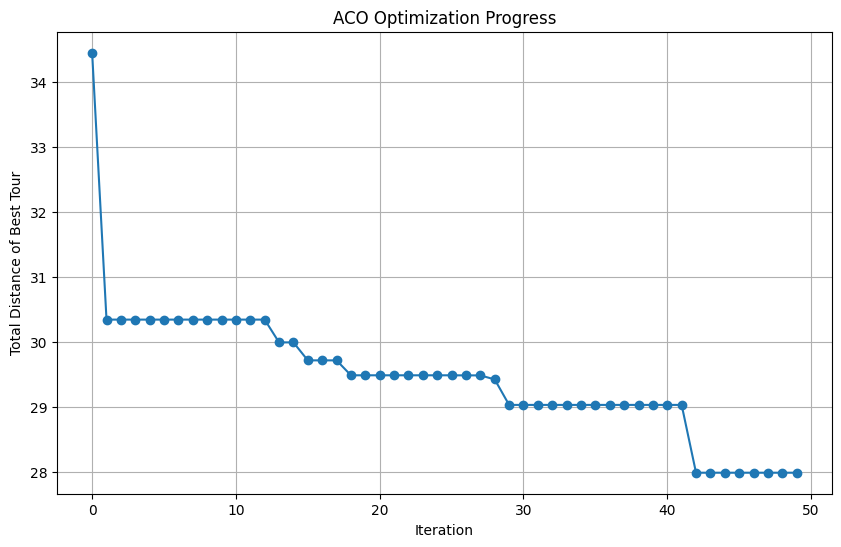

In [5]:
import matplotlib.pyplot as plt


# Plot optimization progress
plt.figure(figsize=(10, 6))
plt.plot(length_history, marker='o')
plt.title('ACO Optimization Progress')
plt.xlabel('Iteration')
plt.ylabel('Total Distance of Best Tour')
plt.grid(True)
plt.show()